# Task B — Modeling & Task C — Anomalies

Implement model and anomaly detection here.

In [1]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from currency_converter import CurrencyConverter
from pathlib import Path
pd.set_option("display.max_columns", 120)
plt.style.use("seaborn-v0_8")
DATA_DIR = Path("../dataset")
sup = pd.read_csv(DATA_DIR/"suppliers.csv")
prod = pd.read_csv(DATA_DIR/"products.csv")
prices = pd.read_csv(DATA_DIR/"price_lists.csv", parse_dates=["valid_from","valid_to"])
po = pd.read_csv(DATA_DIR/"purchase_orders.csv", parse_dates=["order_date","promised_date"])
deliv = pd.read_csv(DATA_DIR/"deliveries.csv", parse_dates=["actual_delivery_date"])
po = po.merge(deliv, on="order_id", how="left")
print(sup.shape, prod.shape, prices.shape, po.shape)


(20, 7) (40, 5) (854, 7) (4307, 20)


### 1. Feature Engineering & Modeling

In [2]:
c = CurrencyConverter(fallback_on_missing_rate=True)

def convert_to_eur(row, price_col, currency_col, date_col):
    if row[currency_col] == "EUR":
        return row[price_col]
    elif row[currency_col] == "USD":
        return c.convert(row[price_col], "USD", "EUR", date=row[date_col].date())
    else:
        return None

In [3]:
po_with_prices = po.merge(prices, on="sku", how="left", suffixes=("","_base"))
po_with_prices["valid"] = (po_with_prices["order_date"] >= po_with_prices["valid_from"]) & (po_with_prices["order_date"] <= po_with_prices["valid_to"])
po_with_prices = po_with_prices[po_with_prices["valid"]].copy()
po_with_prices["price_per_uom_eur"] = po_with_prices.apply(convert_to_eur, args=("price_per_uom", "currency_base", "order_date"), axis=1)
po = po.merge(po_with_prices.groupby("order_id").agg({"valid": "count", "price_per_uom_eur": "median"}), on="order_id", how="left")

In [4]:

df = po.query("cancelled == 0").copy()
df["late_delivery"] = df["late_delivery"].fillna(0).astype(int)
cutoff = pd.Timestamp("2025-03-31")
train = df[df["order_date"] <= cutoff].copy()
valid = df[df["order_date"] > cutoff].copy()

def engineer(d, columns=None):
    out = d.copy()
    out["promised_lead_days"] = (out["promised_date"] - out["order_date"]).dt.days
    out["month"] = out["order_date"].dt.month
    out = out.merge(sup[["supplier_id","preferred","rating","country"]], on="supplier_id", how="left")
    out = out.merge(prod[["sku","hazard_class","base_price_eur"]], on="sku", how="left")
    out["preferred"] = out["preferred"].astype(int)
    out["avail_suppliers_count"] = out["valid"].fillna(0).astype(int)
    out["is_hazard"] = (out["hazard_class"]!="none").astype(int)
    out["unit_price_eur"] = out.apply(convert_to_eur, args=("unit_price", "currency", "order_date"), axis=1)
    out["log_unit_price_eur"] = np.log1p(out["unit_price_eur"])
    out["unit_price_diff"] = out["unit_price_eur"] - out["price_per_uom_eur"].fillna(out["base_price_eur"]).astype(float)

    if columns is None:
        out = pd.get_dummies(out, columns=["ship_mode","incoterm","payment_terms","month","country"], drop_first=True, dtype=int)
    else:
        out = pd.get_dummies(out, columns=["ship_mode","incoterm","payment_terms","month","country"], dtype=int)
        out = out.reindex(columns=columns, fill_value=0)
    return out

X_train = engineer(train); X_valid = engineer(valid, X_train.columns)
y_train = X_train["late_delivery"]; y_valid = X_valid["late_delivery"]
cols_drop = ["order_id","order_date","promised_date","actual_delivery_date",
             "order_notes","sku","currency","hazard_class","late_delivery",
             "delay_days","delay_reason","cancelled","partial_delivery",
             "unit_price","qty","urgent","supplier_id","base_price_eur",
             "valid","price_per_uom_eur","unit_price_eur"]
X_train = X_train.drop(columns=cols_drop, errors="ignore")
X_valid = X_valid.drop(columns=cols_drop, errors="ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_recall_curve
clf = RandomForestClassifier(n_estimators=300, random_state=0, class_weight="balanced")
clf.fit(X_train, y_train)
p_valid = clf.predict_proba(X_valid)[:,1]
print("PR-AUC:", average_precision_score(y_valid, p_valid))
print("ROC-AUC:", roc_auc_score(y_valid, p_valid))
print("F1-Score (0.5 thresh):", f1_score(y_valid, (p_valid>0.5).astype(int)))

precisions, recalls, thresholds = precision_recall_curve(y_valid, p_valid)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Best F1-Score ({best_threshold:.2f} thresh): {best_f1}")

k = int(len(p_valid) * 0.50)
threshold_top_k = np.sort(p_valid)[-k]
top_k_preds = (p_valid >= threshold_top_k).astype(int)
top_k_f1 = f1_score(y_valid, top_k_preds)
print(f"Top 50% F1-Score ({threshold_top_k:.2f} thresh): {top_k_f1}")

PR-AUC: 0.636024141584629
ROC-AUC: 0.6227242401779095
F1-Score (0.5 thresh): 0.574585635359116
Best F1-Score (0.28 thresh): 0.6878980891719745
Top 50% F1-Score (0.49 thresh): 0.5896414342629482


### 2. Reliability Diagram & Brier Score

Brier Score: 0.2385


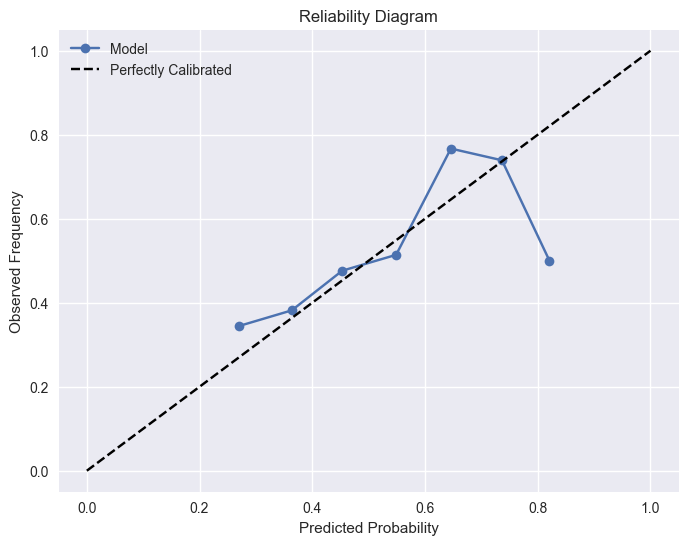

In [5]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt

# Brier Score
brier = brier_score_loss(y_valid, p_valid)
print(f"Brier Score: {brier:.4f}")

# Reliability diagram
prob_true, prob_pred = calibration_curve(y_valid, p_valid, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0, 1], [0, 1], 'k--', label="Perfectly Calibrated")
plt.title("Reliability Diagram")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.legend()
plt.show()


##### Under-confident in the low-to-mid range (e.g., predicts 0.3 -> actual 0.35)
##### Over-confident at high probabilities (e.g., predicts 0.8 -> actual 0.5)

##### Fixes for Calibration: collect more balanced and diverse data, reduce overfitting (simpler model, more regularization), fitting a regressor (called a calibrator) that maps the output of the classifier to a calibrated probability

### 3. Slice Analysis 

In [6]:
def slice_performance(data, preds, labels, group_col):
    slices = []
    for val in data[group_col].unique():
        idx = (data[group_col] == val)
        if idx.sum() < 10:  # skip very small groups
            continue
        y_true_slice = labels[idx]
        y_pred_slice = preds[idx]
        pr_auc = average_precision_score(y_true_slice, y_pred_slice)
        roc_auc = roc_auc_score(y_true_slice, y_pred_slice)
        f1 = f1_score(y_true_slice, (y_pred_slice > 0.5).astype(int))
        slices.append((val, idx.sum(), pr_auc, roc_auc, f1))
    return pd.DataFrame(slices, columns=[group_col, "count", "PR_AUC", "ROC_AUC", "F1"])

# Merge validation with predictions
valid_with_preds = valid.copy()
valid_with_preds = valid_with_preds.merge(sup[["supplier_id","country"]], on="supplier_id", how="left")
valid_with_preds["p_late"] = p_valid

# Analyze by ship_mode
ship_mode_perf = slice_performance(valid_with_preds, valid_with_preds["p_late"], valid_with_preds["late_delivery"], "ship_mode")
country_perf = slice_performance(valid_with_preds, valid_with_preds["p_late"], valid_with_preds["late_delivery"], "country")

# Create distance buckets (example: short, medium, long)
bins = [0, 200, 550, 850, 1200, 2000]
labels = ["<200km", "200-550km", "550-850km", "850-1200km", ">1200km"]
valid_with_preds["distance_bucket"] = pd.cut(valid_with_preds["distance_km"], bins=bins, labels=labels)
distance_perf = slice_performance(valid_with_preds, valid_with_preds["p_late"], valid_with_preds["late_delivery"], "distance_bucket")

print("\nPerformance by Ship Mode:\n", ship_mode_perf)
print("\nPerformance by Supplier Country:\n", country_perf)
print("\nPerformance by Distance Bucket:\n", distance_perf)



Performance by Ship Mode:
   ship_mode  count    PR_AUC   ROC_AUC        F1
0      road    408  0.590361  0.591860  0.508197
1       sea    161  0.745925  0.601888  0.734177
2       air    129  0.482337  0.627554  0.452381
3      rail     37  0.613133  0.492690  0.486486

Performance by Supplier Country:
   country  count    PR_AUC   ROC_AUC        F1
0      US     39  0.701981  0.543056  0.275862
1      IT    116  0.558320  0.585638  0.545455
2      IN    107  0.663477  0.647275  0.576577
3      PL    144  0.594256  0.629468  0.560606
4      NL     94  0.646952  0.645191  0.556962
5      CZ     72  0.557016  0.527027  0.500000
6      CN     73  0.755503  0.688095  0.607595
7      FR     26  0.841172  0.806061  0.774194
8      DE     35  0.607347  0.571895  0.628571
9      UK     29  0.903270  0.744048  0.782609

Performance by Distance Bucket:
   distance_bucket  count    PR_AUC   ROC_AUC        F1
0       550-850km    381  0.665627  0.622346  0.586387
1      850-1200km    152  0.678

##### Performance varies significantly by ship mode, suggesting the model does not generalize equally across logistics channels
##### Strong performance in Europe, weaker for US and India. This may relate to differences in shipping practices
##### The model struggles most on short distance shipments, possibly because delays there are influenced by operational factors not captured in features
##### To address disparties, we can do threshold adjustment per segment, rebalancing & sampling, segment-specific models training

In [7]:
valid_with_preds[["order_id", "p_late"]].to_csv("predictions.csv", index=False)

### 4. Price Anomaly Detection

In [8]:

prices_ = prices.copy()
prices_["price_eur"] = np.where(prices_["currency"]=="EUR", prices_["price_per_uom"], prices_["price_per_uom"]/1.09)
prices_ = prices_.merge(prod[["sku", "base_price_eur"]], on="sku", how="left")
results = []
for (sid, sku), g in prices_.groupby(["supplier_id","sku"]):
    g = g.sort_values("valid_from").copy()
    x = np.log1p(g["price_eur"])
    base = np.log1p(g["base_price_eur"].iloc[0])
    # med = np.median(x)
    # mad = np.median(np.abs(x - med)) or 1e-6
    # z = 0.6745*(x - med)/mad
    deviation = x - base
    mad = np.median(np.abs(deviation)) or 1e-6
    z = 0.6745 * deviation / mad
    g["robust_z"] = z
    # top = g.loc[g["robust_z"].abs().sort_values(ascending=False).head(3).index]
    for _, r in g.iterrows():
        results.append({"supplier_id": sid, "sku": sku, "valid_from": r["valid_from"], "price_eur": r["price_eur"], "base_price_eur": r["base_price_eur"], "robust_z": r["robust_z"]})

anomalies_df = pd.DataFrame(results)

threshold = 3.5
flagged = anomalies_df[anomalies_df["robust_z"].abs() > threshold]

top_n = flagged.sort_values("robust_z", key=lambda s: s.abs(), ascending=False).head(10)
top_n


,supplier_id,sku,valid_from,price_eur,base_price_eur,robust_z
699,17,SKU00022,2024-12-30,17.963303,10.89,53.638832
92,3,SKU00020,2024-07-01,47.580000,23.19,38.994744
209,6,SKU00005,2024-12-30,17.669725,11.02,35.551107
472,12,SKU00011,2024-01-01,30.960000,59.69,-29.614586
403,9,SKU00038,2024-12-30,24.348624,12.02,28.170955
41,2,SKU00005,2024-07-01,5.357798,11.02,-21.299394
397,9,SKU00033,2024-12-30,15.040000,7.32,17.762091
278,7,SKU00017,2024-07-01,3.678899,7.59,-16.966141
569,15,SKU00001,2024-07-01,5.550000,10.86,-15.630236
233,6,SKU00021,2024-12-30,26.980000,13.42,14.483459


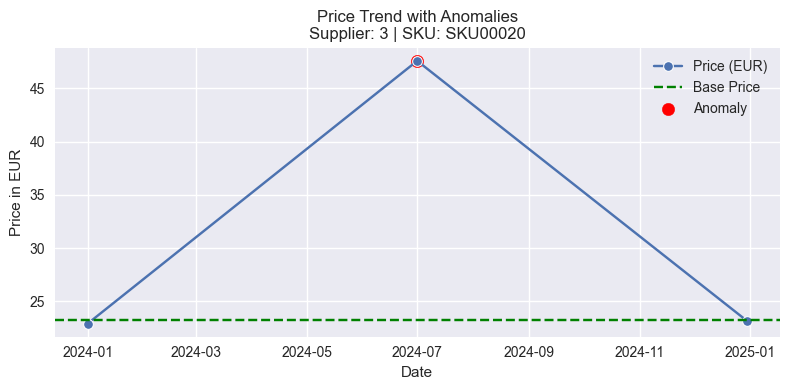

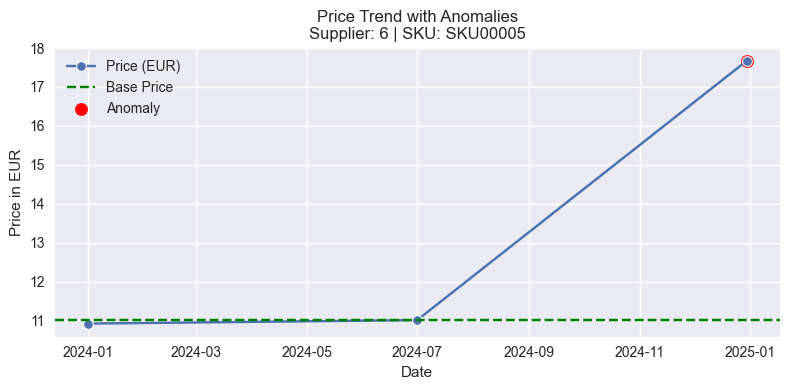

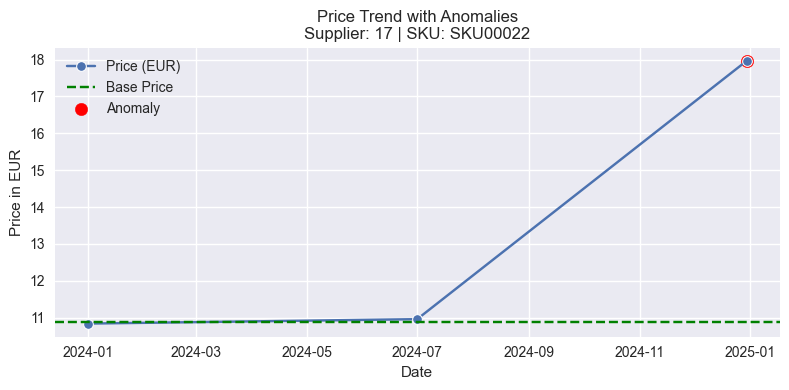

In [9]:
sample_skus = top_n[["supplier_id", "sku"]].drop_duplicates().head(3)
filtered_anomalies = anomalies_df.merge(sample_skus, on=["supplier_id", "sku"], how="inner")

for (supplier, sku), subset in filtered_anomalies.groupby(["supplier_id", "sku"]):
    base_price = subset["base_price_eur"].iloc[0]

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=subset, x="valid_from", y="price_eur", marker="o", label="Price (EUR)")
    plt.axhline(y=base_price, color="green", linestyle="--", label="Base Price")

    anomaly_points = subset[subset["robust_z"].abs() > threshold]
    plt.scatter(anomaly_points["valid_from"], anomaly_points["price_eur"], color="red", s=80, label="Anomaly")

    plt.title(f"Price Trend with Anomalies\nSupplier: {supplier} | SKU: {sku}")
    plt.xlabel("Date")
    plt.ylabel("Price in EUR")
    plt.legend()
    plt.tight_layout()
    plt.show()


##### A threshold of 3.5 roughly corresponds to the same level of extremeness as a standard z-score of 3 under normal conditions.
##### Reviewing alerts operationally can be done by validating anomalies against cost changes, corresponding events in supplier country (e.g., inflation) or unexpected supplier behavior.